<a href="https://colab.research.google.com/github/nausya/tesis/blob/main/saham_indo_bei.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install yfinance

     |████████████████████████████████| 63 kB 1.4 MB/s 
     |████████████████████████████████| 6.4 MB 27.1 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
#Impor Library
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib. pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import LSTM,SimpleRNN,GRU,Dense,Dropout
from sklearn.model_selection import TimeSeriesSplit
import matplotlib. dates as mandates
from sklearn import linear_model
from keras.models import Sequential
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras import optimizers
from tensorflow.keras.optimizers import Adamax, Adam, RMSprop 
from keras.models import load_model
from keras.utils.vis_utils import plot_model
import timeit
from sklearn.metrics import make_scorer, r2_score, confusion_matrix, mean_squared_error
from sklearn import metrics
from math import sqrt
import yfinance as yf 

# Tampilan layar
pd.set_option('display.max_rows', 800)
pd.set_option('display.max_columns', 500)

In [3]:
#Ambil Data
emiten = "DMAS"
kdemiten = emiten + ".jk"
#df = pd.read_csv(kdemiten,index_col='Date',parse_dates=True,infer_datetime_format=True)
df = yf.download(kdemiten, period='max',parse_dates=True,infer_datetime_format=True)
df.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-03-07,189.0,190.0,184.0,185.0,185.0,55815400
2022-03-08,185.0,191.0,182.0,182.0,182.0,55345500
2022-03-09,183.0,188.0,182.0,186.0,186.0,52816000
2022-03-10,187.0,190.0,187.0,188.0,188.0,59623700
2022-03-11,188.0,190.0,187.0,189.0,189.0,26740700


In [4]:
agg_dict = {'Open': 'first',
          'High': 'max',
          'Low': 'min',
          'Close': 'last',
          'Adj Close': 'last',
          'Volume': 'mean'}

# resampled dataframe
# 'W' means weekly aggregation
df = df.resample('5D').agg(agg_dict)

In [5]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-02-16,190.0,198.0,189.0,195.0,195.0,27722200.0
2022-02-21,195.0,197.0,188.0,189.0,189.0,23102800.0
2022-02-26,190.0,192.0,188.0,190.0,190.0,21426150.0
2022-03-03,190.0,191.0,184.0,185.0,185.0,37778050.0
2022-03-08,185.0,191.0,182.0,189.0,189.0,48631475.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 496 entries, 2015-05-29 to 2022-03-08
Freq: 5D
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       493 non-null    float64
 1   High       493 non-null    float64
 2   Low        493 non-null    float64
 3   Close      493 non-null    float64
 4   Adj Close  493 non-null    float64
 5   Volume     493 non-null    float64
dtypes: float64(6)
memory usage: 27.1 KB


In [7]:
#Print the shape of Dataframe  and Check for Null Values
print("Dataframe Shape: ", df. shape)
print("Null Value Present: ", df.isnull().values.any())

Dataframe Shape:  (496, 6)
Null Value Present:  True


In [8]:
df = df.fillna(method = "ffill")

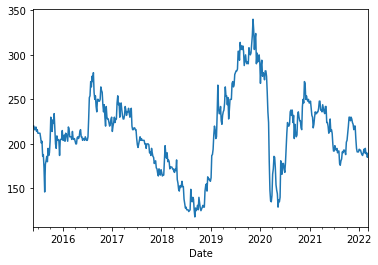

In [9]:
#Plot the True Adj Close Value
df["Close"].plot()

In [10]:
#Set Target Variable
output_var = pd.DataFrame(df['Close'])
#Selecting the Features
features = ['Open', 'High', 'Low', 'Volume']

In [11]:
#Scaling
scaler = StandardScaler()# standar scaler lebih baik
#scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(df[features])
feature_transform= pd.DataFrame(columns=features, data=feature_transform, index=df.index)
feature_transform.head()

,Open,High,Low,Volume
Date,,,,
2015-05-29,0.270854,0.276110,0.097220,10.274509
2015-06-03,0.156810,0.120862,0.239675,0.159124
2015-06-08,0.134001,-0.012207,0.049735,-0.010150
2015-06-13,0.019958,-0.034385,0.097220,-0.496881
2015-06-18,0.065575,0.009971,0.168448,-0.728232


In [12]:
#Splitting to Training set and Test set
timesplit= TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(feature_transform):
        X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(train_index): (len(train_index)+len(test_index))].values.ravel()

In [13]:
#Process the data for LSTM
trainX =np.array(X_train)
testX =np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

In [14]:
#Rencana Model

jml_epochs= 100
input_optimasi = 'Adam'
input_lr = '001'

#Set optimizer
if input_lr == '01':
  lr=0.1
elif input_lr == '001':
  lr=0.01
elif input_lr == '0001':
  lr=0.001

if input_optimasi == 'SGD':
  opt = SGD(learning_rate=lr, momentum=0.9)
elif input_optimasi == 'Adam':
  opt = Adam(learning_rate=lr)
elif input_optimasi == 'RMSprop':
  opt = RMSprop(learning_rate=lr)


model = Sequential()
model.add(SimpleRNN(32, input_dim=len(features), activation='relu', kernel_initializer='he_normal'))
#model.add(Dense(10, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae','mse'])

model.summary()
#plot_model(model, show_shapes=True, show_layer_names=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                1184      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 1,217
Trainable params: 1,217
Non-trainable params: 0
_________________________________________________________________


In [15]:
#Model Training

start = timeit.default_timer()
history=model.fit(X_train, y_train, epochs=jml_epochs, batch_size=16, verbose=1, shuffle=False)
stop = timeit.default_timer()

Epoch 1/100
29/29 [==============================] - 4s 8ms/step - loss: 47205.6953 - mae: 212.4538 - mse: 47205.6953
Epoch 2/100
29/29 [==============================] - 0s 8ms/step - loss: 44717.0625 - mae: 206.5883 - mse: 44717.0625
Epoch 3/100
29/29 [==============================] - 0s 9ms/step - loss: 40819.8750 - mae: 196.9386 - mse: 40819.8750
Epoch 4/100
29/29 [==============================] - 0s 10ms/step - loss: 35028.4648 - mae: 181.4549 - mse: 35028.4648
Epoch 5/100
29/29 [==============================] - 0s 10ms/step - loss: 27781.0234 - mae: 159.5287 - mse: 27781.0234
Epoch 6/100
29/29 [==============================] - 0s 9ms/step - loss: 20118.9766 - mae: 132.6203 - mse: 20118.9766
Epoch 7/100
29/29 [==============================] - 0s 7ms/step - loss: 13371.4688 - mae: 107.5666 - mse: 13371.4688
Epoch 8/100
29/29 [==============================] - 0s 10ms/step - loss: 8639.8096 - mae: 84.4720 - mse: 8639.8096
Epoch 9/100
29/29 [==============================] - 0s 

In [16]:
#LSTM Prediction
y_pred= model.predict(X_test)

In [17]:
print ('R Squared =',r2_score(y_test, y_pred))
ORCL_R2_MODEL = r2_score(y_test, y_pred)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
ORCL_MAE_MODEL = metrics.mean_absolute_error(y_test, y_pred)

print('Mean Absolute Percentage Error:', metrics.mean_absolute_percentage_error(y_test, y_pred))
ORCL_MAPE_MODEL = metrics.mean_absolute_percentage_error(y_test, y_pred)

print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
ORCL_RMSE_MODEL = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

R Squared = 0.9644590636464351
Mean Absolute Error: 2.3190677218967015
Mean Absolute Percentage Error: 0.011609502735590478
Root Mean Squared Error: 2.926637610209371


In [18]:
from prettytable import PrettyTable
waktu = stop - start
nmtabel = PrettyTable(["Nama Emiten","R2","MAE","MAPE","RMSE","Waktu"])
nmtabel.add_row([emiten,'{:.2f}'.format(ORCL_R2_MODEL), '{:.2f}'.format(ORCL_MAE_MODEL), '{:.2f}'.format(ORCL_MAPE_MODEL), '{:.2f}'.format(ORCL_RMSE_MODEL),'{:.0f}'.format(waktu)])
#nmtabel.add_row(["5","Paper Acuan","ORCL","LSTM","100","01","Adam","0.90153", "0.98621","1.97875","1.39695","-"])
print(nmtabel)

+-------------+------+------+------+------+-------+
| Nama Emiten |  R2  | MAE  | MAPE | RMSE | Waktu |
+-------------+------+------+------+------+-------+
|     DMAS    | 0.96 | 2.32 | 0.01 | 2.93 |   31  |
+-------------+------+------+------+------+-------+


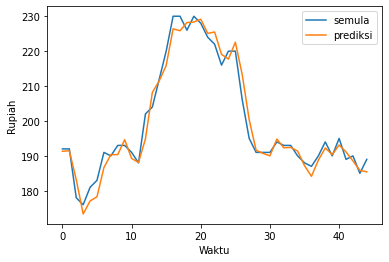

In [19]:
#grafik
plt.plot(y_test, label='semula')
plt.plot(y_pred, label='prediksi')
#plt.title("Prediksi Harga Saham")
plt.xlabel('Waktu')
plt.ylabel('Rupiah')
plt.legend()
#plt.savefig('BBKP.jpeg')
plt.show()

In [20]:
#clear session
K.clear_session()